In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy import signal
from astropy.convolution import convolve, Gaussian1DKernel
from scipy.signal import find_peaks
import numpy as np
from scipy.signal import correlate

In [87]:
class OlgeFeatures:
    def __init__(self,path) -> None:
        self.file_path = path
        self.bin_index = None
        self.time = None
        self.mag = None
        self.frequency = np.linspace(0.0003, 24, 800000)
        self.power = None
        self.peaks = None
        self.features = None

    def init(self):
        self.time, self.mag = self._read_table()
        self.power = self._lomb_scargle()
        self._allis_filter()
        freq_index = self._get_indexof_log_span(self.frequency,10)
        freq_index.insert(0, 0)
        self.peaks = self._find_peak_of_index(self.power,freq_index)
        self.bin_index = self._bin_split()
        self.features = self._generate_features_90()

        return self.features
    
    def _read_table(self):
        data = pd.read_table(self.file_path,sep='\\s+',names=['time','mag','err'])
        return data.iloc[:,0],data.iloc[:,1]

    def _lomb_scargle(self):
        return LombScargle(self.time, self.mag).power(self.frequency)

    def _find_first_greater(self, array, value):
        left = 0
        right = len(array) - 1
        while left <= right:
            mid = (left + right) // 2
            if array[mid] <= value:
                left = mid + 1
            else:
                right = mid - 1
        return left
        
    def _allis_filter(self):
        pass

    def _get_indexof_log_span(self, data, bin):
        log_end = np.log10(data[-1] - data[1000])
        log_start =np.log10(data[1000])
        log_step = (log_end - log_start) / bin

        value_arr = np.array([(10 ** (log_start + i * log_step)) for i in range(1,bin + 1)])
        index_arr = []
        
        for i in value_arr:
            index_arr.append(self._find_first_greater(data,i))
        return index_arr
    
    def _find_peak_of_index(self,data, index_arr): 
        peaks = np.array([])
        for i in range(len(index_arr) - 1):
            start = index_arr[i]
            end = index_arr[i + 1]
            peak,_ = find_peaks(data[start:end],distance=(end - start) ** 0.5)
            peak += start
            peaks = np.concatenate((peaks,peak))
        return peaks
    
    def _bin_split(self):
        freq_idx_1 = self._find_first_greater(self.frequency, 1)
        index_of_1_log_arr = self._get_indexof_log_span(self.frequency[0:freq_idx_1], 7)
        index_of_1_log_arr.insert(0, 0)
        index_of_1_log_arr = np.array(index_of_1_log_arr)
        index_freq_1dot5_to_24 = self._find_first_greater(self.frequency, 1.5)
        index_of_arr = np.linspace(index_freq_1dot5_to_24,len(self.frequency), 11)
        index_of_arr = np.int_(index_of_arr)
        return np.concatenate((index_of_1_log_arr,index_of_arr))
        

    def _normalized_iqr(self,array):
        q1 = np.percentile(array, 25)
        q3 = np.percentile(array, 75)
        iqr = q1 - q3
        med = np.median(array)
        normalized_arr = (array - med) / iqr
        return normalized_arr
    
    def _generate_features_90(self):
        featrues = np.zeros(90,dtype=np.float64)        
        f_idx = 0
        bins_idx = self.bin_index
        peaks = self.peaks
        power = self.power

        for i in range(len(bins_idx) - 1):
            current_peak = np.int_(peaks[(peaks > bins_idx[i]) & (peaks < bins_idx[i + 1])])
            current_power = power[current_peak]
            current_power = np.sort(np.log(current_power))[::-1][:5]
            current_power = self._normalized_iqr(current_power)
            featrues[f_idx:f_idx + len(current_power)] = current_power
            f_idx += len(current_power)
        return featrues

In [92]:
fe = OlgeFeatures(r"../datasets\OCVS\ECL\C\I\OGLE-BLG-ECL-000002.dat")
fe.init()
#The first 5 maximums of the log-power for each the 18 bins
#每个18个bin的对数功率的前5个最大值
fe.features

array([ -0.66515967,  -0.24411344,  -0.        ,   0.75588656,
         0.7642123 ,  -0.75443221,  -0.68601183,  -0.        ,
         0.31398817,   0.51465888,  -2.97492611,  -0.76965903,
        -0.        ,   0.23034097,   0.80400632, -20.81309047,
        -0.82195859,  -0.        ,   0.17804141,   1.43892843,
        -0.49699125,  -0.4825081 ,  -0.        ,   0.5174919 ,
         1.28745123,  -7.95084533,  -0.70530063,  -0.        ,
         0.29469937,   1.97753636,  -1.67120792,  -0.04296241,
        -0.        ,   0.95703759,   2.74974036,  -1.10019643,
        -0.92446915,  -0.        ,   0.07553085,   0.10543402,
        -3.03034453,  -0.77671354,  -0.        ,   0.22328646,
         0.43800372,  -2.82045157,  -0.13701222,  -0.        ,
         0.86298778,   2.88210168,  -1.66958436,  -0.83836515,
        -0.        ,   0.16163485,   0.20581882,  -1.21771016,
        -0.29759438,  -0.        ,   0.70240562,   1.15348756,
        -0.8545871 ,  -0.84907916,  -0.        ,   0.15

In [93]:
#light curve fetures
import statsmodels.api as sm
from statsmodels import robust
import statsmodels.stats.stattools as stats

time,mag = fe.time,fe.mag
# 使用HuberT函数拟合模型
rlm_model = sm.RLM(time, mag, M=sm.robust.norms.HuberT())

# 拟合模型并打印参数
rlm_results = rlm_model.fit()
hubermean = rlm_results.params
print(hubermean)

mag    194.999428
dtype: float64


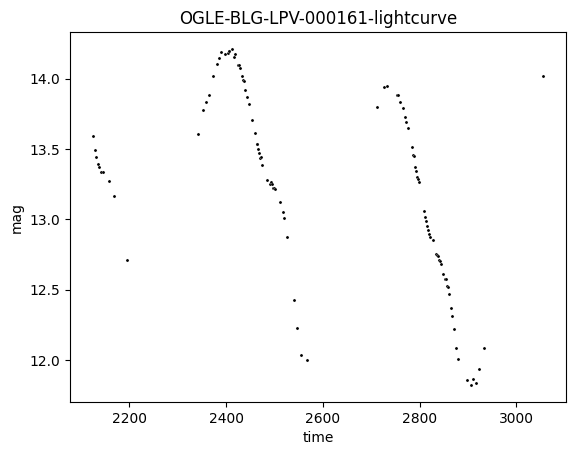

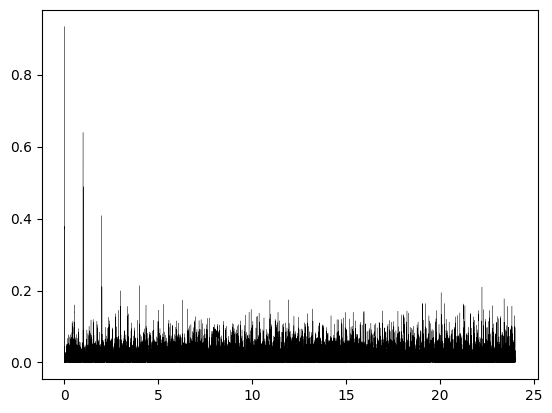

In [94]:
time,mag = fe.time,fe.mag
power = fe.power
frq = fe.frequency
import seaborn as sns
sns.scatterplot(x=time,y=mag,s=5,color='black')
plt.title("OGLE-BLG-LPV-000161-lightcurve")
plt.show()



def read_table(file_path):
    data = pd.read_table(file_path,sep='\\s+',names=['time','mag','err'])
    return data

data = read_table(r"../datasets\OCVS\CEP\T2\I\OGLE-BLG-T2CEP-006.dat")
data.head(10)

#sns.pointplot(x=fe.frequency,y=fe.power,s=3,color='black')
plt.plot(frq,power,color='black',linewidth=0.2)

In [95]:
#MAD
mad = robust.mad(mag)
print("MAD of mag:{}".format(mad))

MAD of mag:0.7309228937232648


In [96]:
#IQR
mag_sort = np.sort(mag)
q1 = np.percentile(mag_sort, 25)
q3 = np.percentile(mag_sort, 75)
iqr = q3 - q1
print("IQR:{}".format(iqr))


IQR:1.0732500000000016


In [97]:
#IQR / huber_mean
ratio = iqr /  hubermean
print("RobustMeanVariance:{}".format(ratio))


RobustMeanVariance:mag    0.005504
dtype: float64


In [98]:
#The median of the magnitudes over the 95th percentile minus 
#the median of the magnitudes under the 5th percentile

mag_95 = np.percentile(mag, 95)
mag_5 = np.percentile(mag, 5)
median_95 = np.median(mag[mag > mag_95])
median_5 = np.median(mag[mag < mag_5])
Amplitude = median_95 - median_5
print("Amplitude:{}".format(Amplitude))



Amplitude:2.3305000000000007


In [99]:
#Range of a cumulative sum of the magnitudes
#https://ui.adsabs.harvard.edu/abs/2014A%26A...566A..43K/abstract
cumsum_mag = np.cumsum(mag)
cumsum_mag_range = np.ptp(cumsum_mag)
print("cumsum_mag_range:{}".format(cumsum_mag_range))
def spec_cumsum(x):
    return np.cumsum((x - np.mean(x)) / (np.std(x) * len(x)))

spec_cumsum_mag = spec_cumsum(mag)
spec_cumsum_mag_range = np.ptp(spec_cumsum_mag)
print("spec_cumsum_mag_range:{}".format(spec_cumsum_mag_range))

cumsum_mag_range:1418.0890000000009
spec_cumsum_mag_range:0.3257814627314251


In [100]:
#Percentage of points beyond 1𝜎 from the weighted mean
def percentage_beyond_sigma(data, weights):
    # 计算加权平均值
    weighted_mean = np.average(data, weights=weights)
    # 计算标准差
    std_dev = np.sqrt(np.average((data - weighted_mean)**2, weights=weights))
    
    # 计算超出1𝜎的点的数量
    beyond_sigma = np.sum(np.abs(data - weighted_mean) > std_dev)
    
    # 计算超出1𝜎的点的百分比
    percentage = beyond_sigma / len(data) * 100
    
    return percentage
w = None
percentage = percentage_beyond_sigma(mag, w)
print("percentage_beyond_sigma:{}".format(percentage))


percentage_beyond_sigma:37.96296296296296


In [101]:
#Fraction of points within a tenth of the magnitude range of the median magnitude
#在中位数范围的十分之一的点的星等百分比
mag_sort = np.sort(mag)
mag_range = np.ptp(mag_sort)
mag_median = np.median(mag_sort)
mag_range_tenth = mag_range / 10
mag_median_range = mag_median + mag_range_tenth
mag_median_range_count = np.sum((mag_sort > mag_median - mag_range_tenth) & (mag_sort < mag_median_range))
print("mag_median_range_count:{}".format(mag_median_range_count))
mag_median_range_fraction = mag_median_range_count / len(mag_sort)
print("mag_median_range_fraction:{}".format(mag_median_range_fraction))


mag_median_range_count:31
mag_median_range_fraction:0.28703703703703703


In [102]:
#Largest percentage difference between either 
#the maximum or minimum magnitude and the median
#最大或最小星等与中位数之间的最大百分比差异
def largest_percentage_difference(arr):
    median = np.median(arr)  
    max_val = np.max(arr)  
    min_val = np.min(arr)  

    diff1 = abs(max_val - median) / median * 100  
    diff2 = abs(min_val - median) / median * 100  

    return max(diff1, diff2) 

largest_percentage_difference = largest_percentage_difference(mag)
print("largest_percentage_difference:{}".format(largest_percentage_difference))


largest_percentage_difference:11.367639893557206


In [103]:
#The fraction of points over the 3rd quartile plus 1.5 times 
#the interquartile range of the magnitude
#星等的四分位数加上1.5倍的四分位数范围的点的星等百分比
#this work
mag_sort = np.sort(mag)
q3 = np.percentile(mag_sort, 75)
q1 = np.percentile(mag_sort, 25)
iqr = q3 - q1
mag_3rd = q3 + 1.5 * iqr
mag_3rd_count = np.sum(mag_sort > mag_3rd)
mag_3rd_fraction = mag_3rd_count / len(mag_sort)
print("mag_3rd_fraction:{}".format(mag_3rd_fraction))


mag_3rd_fraction:0.0


In [104]:
#Median based measure of the skew
#基于中位数的偏度测量
def median_based_skew(arr):
    median = np.median(arr)
    mean = np.mean(arr)
    std = np.std(arr)
    skew = 3 * (mean - median) / std
    return skew

median_based_skew = median_based_skew(mag)
print("median_based_skew:{}".format(median_based_skew))


median_based_skew:-0.38065676206921967


In [105]:
#Flux Percentile Ratio Mid-20: Sorted flux percentile ratio 𝐹40,60/𝐹5,95
#Flux Percentile Ratio Mid-35: Sorted flux percentile ratio 𝐹32.5,67.5/𝐹5,95
#Flux Percentile Ratio Mid-50: Sorted flux percentile ratio 𝐹25,75/𝐹5,95
#Flux Percentile Ratio Mid-65: Sorted flux percentile ratio 𝐹17.5,82.5/𝐹5,95
#Flux Percentile Ratio Mid-80: Sorted flux percentile ratio 𝐹10,90/𝐹5,95

def flux_percentile_ratio_mid20(arr):
    arr_sort = np.sort(arr)
    arr_5 = np.percentile(arr_sort, 5)
    arr_95 = np.percentile(arr_sort, 95)
    arr_40 = np.percentile(arr_sort, 40)
    arr_60 = np.percentile(arr_sort, 60)
    return (arr_40 - arr_60) / (arr_5 - arr_95)

def flux_percentile_ratio_mid35(arr):
    arr_sort = np.sort(arr)
    arr_5 = np.percentile(arr_sort, 5)
    arr_95 = np.percentile(arr_sort, 95)
    arr_32_5 = np.percentile(arr_sort, 32.5)
    arr_67_5 = np.percentile(arr_sort, 67.5)
    return (arr_32_5 - arr_67_5) / (arr_5 - arr_95)

def flux_percentile_ratio_mid50(arr):
    arr_sort = np.sort(arr)
    arr_5 = np.percentile(arr_sort, 5)
    arr_95 = np.percentile(arr_sort, 95)
    arr_25 = np.percentile(arr_sort, 25)
    arr_75 = np.percentile(arr_sort, 75)
    return (arr_25 - arr_75) / (arr_5 - arr_95)

def flux_percentile_ratio_mid65(arr):
    arr_sort = np.sort(arr)
    arr_5 = np.percentile(arr_sort, 5)
    arr_95 = np.percentile(arr_sort, 95)
    arr_17_5 = np.percentile(arr_sort, 17.5)
    arr_82_5 = np.percentile(arr_sort, 82.5)
    return (arr_17_5 - arr_82_5) / (arr_5 - arr_95)

def flux_percentile_ratio_mid80(arr):
    arr_sort = np.sort(arr)
    arr_5 = np.percentile(arr_sort, 5)
    arr_95 = np.percentile(arr_sort, 95)
    arr_10 = np.percentile(arr_sort, 10)
    arr_90 = np.percentile(arr_sort, 90)
    return (arr_10 - arr_90) / (arr_5 - arr_95)

flux_percentile_ratio_mid20 = flux_percentile_ratio_mid20(mag)
flux_percentile_ratio_mid35 = flux_percentile_ratio_mid35(mag)
flux_percentile_ratio_mid50 = flux_percentile_ratio_mid50(mag)
flux_percentile_ratio_mid65 = flux_percentile_ratio_mid65(mag)
flux_percentile_ratio_mid80 = flux_percentile_ratio_mid80(mag)

print("flux_percentile_ratio_mid20:{}".format(flux_percentile_ratio_mid20))
print("flux_percentile_ratio_mid35:{}".format(flux_percentile_ratio_mid35))
print("flux_percentile_ratio_mid50:{}".format(flux_percentile_ratio_mid50))
print("flux_percentile_ratio_mid65:{}".format(flux_percentile_ratio_mid65))


flux_percentile_ratio_mid20:0.11741971105180832
flux_percentile_ratio_mid35:0.28386399190208844
flux_percentile_ratio_mid50:0.493811539523328
flux_percentile_ratio_mid65:0.6280597220944145


In [106]:
#Ratio of 𝐹5,95 over the median magnitude
#星等的中位数的𝐹5,95比率
mag_sort = np.sort(mag)
mag_5 = np.percentile(mag_sort, 5)
mag_95 = np.percentile(mag_sort, 95)
mag_median = np.median(mag_sort)
flux_ratio = (mag_95 - mag_5) / mag_median
print("flux_ratio:{}".format(flux_ratio))


flux_ratio:0.1629174318803644


In [107]:
#Robust kurtosis measure based on Stetson variability index
#基于Stetson可变性指数的健壮峰度测量

robust_kurtosis = stats.robust_kurtosis(mag)[0]
# kurtosis_measures是一个包含四个峰度测量值的元组：
# kr1: 标准峰度估计器
# kr2: 基于八分位数的峰度估计器
# kr3: 基于超过期望值的峰度估计器
# kr4: 基于高低分位数之间的差距的峰度测量
print("robust_kurtosis:{}".format(robust_kurtosis))


robust_kurtosis:-0.6900321795094069


In [108]:
#Robust measure of skewness
#健壮偏度测量
robust_skewness = stats.robust_skewness(mag)[1]
##https://www.statsmodels.org/stable/generated/statsmodels.stats.stattools.robust_skewness.html
print("robust_skewness:{}".format(robust_skewness))


robust_skewness:-0.1008618681574638


In [109]:
#Robust measure of the left tail weight
#健壮左尾重量测量ROW
#Robust measure of the right tail weight
#健壮右尾重量测量ROW


In [110]:
#Robust measure of kurtosis based on on exceedance expectations
#基于超出期望值的健壮峰度测量
robust_kurtosis_excess = stats.robust_kurtosis(mag)[2]
print("robust_kurtosis_excess:{}".format(robust_kurtosis_excess))


robust_kurtosis_excess:-0.44650763686300676


In [111]:
#Estimation of the regularity of the light curve variability pattern for window size 50 days
#估计窗口大小为50天的光曲线变化模式的规律性
#Excess Abbe Value 𝑇sub = 50 d/ 100 d/ 250 d
#https://arxiv.org/abs/1406.7785v1
def abbe(y):
    n = len(y)
    y_bar = np.mean(y)
    sum_diff_sq = np.sum(np.diff(y)**2)
    sum_var_sq = np.sum((y - y_bar)**2)
    A = (n / ( 2 * ( n - 1 ))) * (sum_diff_sq / sum_var_sq)
    
    return A

abbe_all = abbe(mag)
print("abbe_all: {}".format(abbe_all))

def excess_abbe(x,y, window_size):
    first = np.where(x >= x[0] + 0.5 * window_size)[0][0]
    end = np.where(x <= x[len(x) - 1] - 0.5 * window_size)[0][-1]
    abbe_value = np.zeros(end - first + 1)
    for i in range(first, end):
        indexes = np.where((x > x[i] - 0.5 * window_size) & (x < x[i] + 0.5 * window_size))
        if(len(indexes[0]) < 5):
            continue    
        y_window = y[indexes[0]]
        abbe_value[i - first] = abbe(y_window)
    ab_remove_zero = abbe_value[abbe_value != 0]
    abbe_mean = np.mean(ab_remove_zero)
    return abbe_mean - abbe(y)

excess_abbe_50 = excess_abbe(time,mag,100)
print("excess_abbe_50: {}".format(excess_abbe_50))

#excess_abbe_100 = excess_abbe(time,mag,100)
#print("excess_abbe_100: {}".format(excess_abbe_100))

#excess_abbe_250 = excess_abbe(time,mag,250)
#print("excess_abbe_250: {}".format(excess_abbe_250))

abbe_all: 0.09232184780556137
excess_abbe_50: -0.038229531529163245


In [112]:
from jdcal import jd2gcal, gcal2jd  

from datetime import datetime, timedelta
# 计算当前日期
current_date = datetime.now()
# 计算目标日期
target_date = current_date + timedelta(days=50)
# 计算日期差
date_diff = target_date - current_date
# 将MJD日期转换为Gregorian日期
mjdt = gcal2jd(target_date.year, target_date.month, target_date.day)[1]
mjds = gcal2jd(current_date.year, current_date.month, current_date.day)[1]
print(mjdt - mjds)

50.0


In [113]:
#Measure of the smoothness of the light curve
#光曲线平滑度的度量
abbe_lc = abbe(mag)
print("abbe: {}".format(abbe_lc))

abbe: 0.09232184780556137


In [114]:
#Robust autocorrelation function length for irregular time series
#不规则时间序列的健壮自相关函数长度
#https://arxiv.org/abs/1212.2398
#Slotted autocorrelation function length
#槽自相关函数长度

def autocorrelation(x):
    result = correlate(x, x, mode='full')
    return result[result.size // 2:]


#另外一种计算方法
autocorr = sm.tsa.acf(mag, nlags=len(mag))
print("autocorr:{}".format(len(autocorr)))

autocorr:108


In [115]:
#Stetson𝐾 applied over the slotted autocorrelation function
#应用于槽自相关函数的Stetson𝐾
#https://iopscience.iop.org/article/10.1086/133808
def stetson_k(y):
    N = len(y)
    sigma = ( ( N / (N - 1) ) ** 0.5 ) * ( y - np.mean(y) ) / np.std(y)
    K = ( 1 / N ) * np.sum(np.abs(sigma)) / ( ( 1 / N ) * np.sum( sigma ** 2 ) ) ** 0.5
    return K

stetson_k_mag = stetson_k(mag)
stetson_k_autocorr = stetson_k(autocorr)
print("stetson_k_mag:{}".format(stetson_k_mag))
print("stetson_k_autocorr:{}".format(stetson_k_autocorr))

stetson_k_mag:0.8204809044078888
stetson_k_autocorr:0.7109565618014586


In [116]:
#Quality of fit 𝜒2QSO/𝜈 for a quasar-like source, assuming 𝑚𝑎𝑔 = 19
#质量拟合𝜒2QSO/𝜈为类星体源，假设𝑚𝑎𝑔 = 19
#https://ui.adsabs.harvard.edu/abs/2011AJ....141...93B/abstract
# --------不懂
    

In [117]:
#Natural logarithm of expected 𝜒2QSO/𝜈 for non-QSO variable
#非QSO变量的预期𝜒2QSO/𝜈的自然对数
#Base 10 logarithm of the period
#--------不懂

best_f:0.0030599689499611876
rcs_phase:1418.0750000000007
rcs_phase_spec:0.4095415790964171


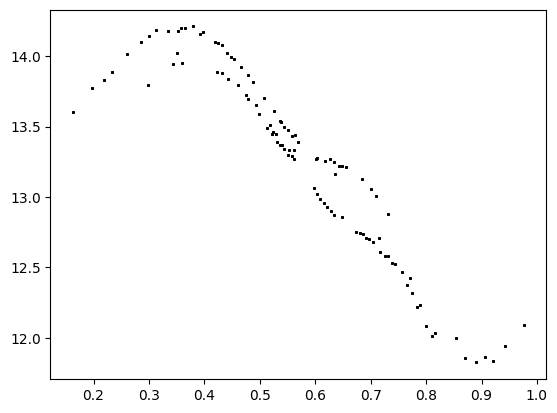

In [118]:
#𝑅CS applied to the phase-folded light curve
#应用于相位折叠光曲线的𝑅CS
#https://ui.adsabs.harvard.edu/abs/2014A%26A...566A..43K/abstract
power = fe.power
#找到最大功率的频率
best_f = fe.frequency[np.argmax(power)]
print("best_f:{}".format(best_f))
period = 1 / best_f

phase = np.mod(time, period) / period
#phase = (time / period) % 1

sorted_indices = np.argsort(phase)

sorted_phase = phase[sorted_indices]
sorted_flux = mag[sorted_indices]


plt.scatter(sorted_phase, sorted_flux,s=1,marker='+',linewidths=2,c='black')


def spec_cumsum(x):
    return np.cumsum((x - np.mean(x)) / (np.std(x) * len(x)))

rcs_phase = np.cumsum(sorted_flux)
rcs_phase = np.ptp(rcs_phase)
print("rcs_phase:{}".format(rcs_phase))

rcs_phase_spec = spec_cumsum(sorted_flux)
rcs_phase_spec = np.ptp(rcs_phase_spec)
print("rcs_phase_spec:{}".format(rcs_phase_spec))



In [119]:
#Variability index 𝜂𝑒 applied to the the folded light curve
#应用于折叠光曲线的可变性指数𝜂𝑒
#https://arxiv.org/abs/1101.2406
#P2p scatter: P/raw : median of the absolute values of the differences
#etween successive magnitudes in the folded light curve normalized by the Median 
#Absolute Deviation (MAD) around the median of the raw light curve.
#P2p scatter: P/raw : 折叠光曲线中连续幅度之间的差值的绝对值的中位数，
#归一化为原始光曲线的中位数绝对偏差（MAD）。
def calculate_median_of_differences(folded_curve):
    # 计算连续幅度之间的差值
    differences = np.diff(folded_curve)
    
    # 计算差值的绝对值
    absolute_differences = np.abs(differences)
    
    # 计算差值的中位数
    median_of_differences = np.median(absolute_differences)
    
    return median_of_differences

def normalize_by_mad(raw_curve, folded_curve):
    # 计算原始光曲线的中位数
    median = np.median(raw_curve)
    
    # 计算原始光曲线的中位数绝对偏差（MAD）
    mad = np.median(np.abs(raw_curve - median))
    
    # 计算折叠光曲线中连续幅度之间差值的中位数
    median_of_differences = calculate_median_of_differences(folded_curve)
    
    # 归一化为MAD
    normalized_median = median_of_differences / mad
    
    return normalized_median

p2p_scatter = normalize_by_mad(mag, sorted_flux)
print("p2p_scatter:{}".format(p2p_scatter))


#another
#https://ui.adsabs.harvard.edu/abs/2014A%26A...566A..43K/abstract
def get_gama(x):
    N = len(x)
    return (1 / (N - 1) * np.std(x) ** 2) * np.sum( np.diff(x) ** 2 )

gama = get_gama(sorted_flux)
print("gama:{}".format(gama))


p2p_scatter:0.25557809330628584
gama:0.015532262903167178


In [120]:
#Amplitudes of the 𝑗𝑡ℎ harmonic of the 𝑖𝑡ℎ period
#https://arxiv.org/abs/1101.2406
#𝑖𝑡ℎ 周期的 𝑗𝑡ℎ 谐波的振幅
from scipy.optimize import curve_fit
best_f = fe.frequency[np.argmax(power)]
def harmonic_func(x, a1, a2, a3, a4, b1, b2, b3, b4, b0):
    a = np.array([a1, a2, a3, a4])
    b = np.array([b1, b2, b3, b4])
    y = np.zeros(len(x))
    for i in range(4):
        y += a[i] * np.sin(2 * np.pi * best_f * (i + 1) * x) + b[i] * np.cos(2 * np.pi * best_f * (i + 1) * x)
    y += b0
    return y

popt, pcov = curve_fit(harmonic_func, time, mag,maxfev = 1000000)
print(popt)


[ 8.03773031e-01  1.11565616e-01  7.68801734e-02 -3.49676566e-02
 -7.16449542e-01 -1.37527400e-01  1.21894370e-02 -5.91197877e-03
  1.30906422e+01]


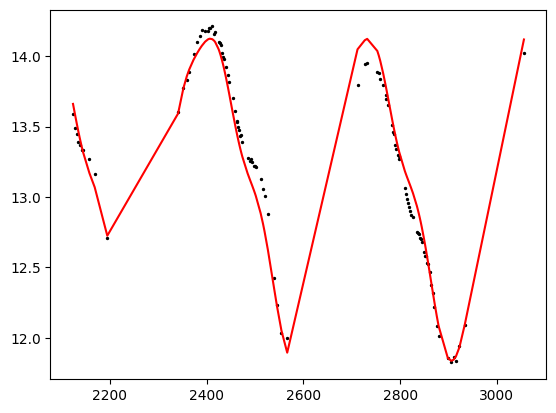

In [121]:
# 计算拟合曲线的 y 值
y_fit = harmonic_func(time, *popt)

# 绘制原始数据点
plt.scatter(time, mag, label='原始数据', color='black', s=2)
# 绘制拟合曲线
plt.plot(time, y_fit, label='拟合曲线', color='red')


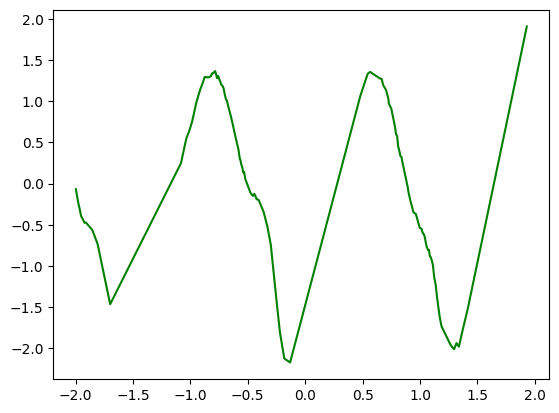

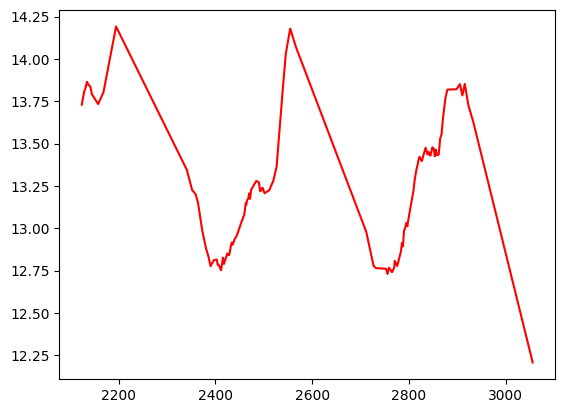

In [122]:
from scipy.linalg import eigh

def whiten(x,y):
    # 去中心化
    x_ = x - np.mean(x)
    y_ = y - np.mean(y)

    #尺度标准化
    x_ = x_ / np.std(x_)
    y_ = y_ / np.std(y_)
    
    # 计算数据的协方差矩阵
    covariance_matrix = np.cov(x_, y_)

    # 计算特征值和特征向量
    eigenvalues, eigenvectors = eigh(covariance_matrix)

    # 计算白化矩阵
    whitening_matrix = np.dot(np.dot(eigenvectors, np.diag(1.0 / np.sqrt(eigenvalues))), eigenvectors.T)

    # 对原始数据进行白化
    whitened_data = np.dot(whitening_matrix, np.vstack((x_, y_)))

    # 提取白化后的时间和数据
    return whitened_data[0], whitened_data[1]

whitened_time, whitened_mag = whiten(time, mag)
t = (time - np.mean(time)) / np.std(time)
plt.plot(t, whitened_mag, label='白化数据', color='green')
plt.show()


"""
Next, this curve was subtracted from the time series (prewhitening) and a new Lomb-Scargle 
periodogram was computed. The same procedure was repeated until three frequencies were found. 
Finally, the three frequencies were used to make a harmonic best-fit to the 
original (trend subtracted) time series:
"""

y_new = y_fit - whitened_mag
plt.plot(time, y_new, color='red')
#plt.scatter(time, mag, color='blue',s=0.1)
plt.show()

new_power_ = LombScargle(time, y_new).power(fe.frequency)
#plt.plot(fe.frequency, new_power, label='白化后的周期图', color='green')

[-254.2389588    87.16442837  -29.44289736    1.72853183 -205.25435798
   30.95128053   18.996529     -5.97880639  513.64170032 -202.31952972
   72.40817251  -14.21715029  -56.13467826   62.18969495  -33.57216443
    8.68414869  174.80777681 -102.11444064   38.45865473   -5.19587143
 -128.47673235   68.59796703  -48.01915356    8.34945438    3.37245573]


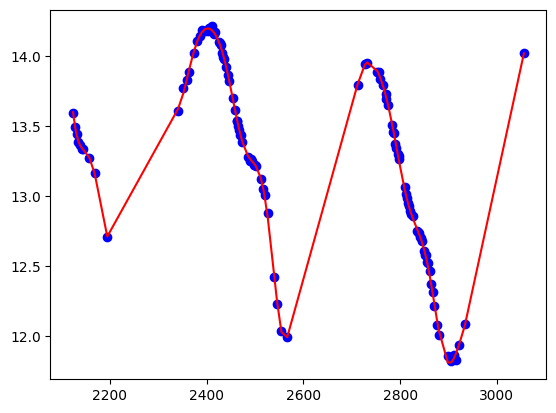

In [123]:
#取前三个最大的频率
new_best_f = fe.frequency[np.argsort(new_power_)[-3:]]


def best_func(x,*params):
    def harmonic_func(x, a1, a2, a3, a4, b1, b2, b3, b4,best_f, b0):
        a = np.array([a1, a2, a3, a4])
        b = np.array([b1, b2, b3, b4])
        y = np.zeros(len(x))
        for i in range(4):
            y += a[i] * np.sin(2 * np.pi * best_f * (i + 1) * x) + b[i] * np.cos(2 * np.pi * best_f * (i + 1) * x)
        y += b0
        return y
    
    a = params[:12]
    b = params[12:24]
    b0 = params[24]
    y = np.zeros(len(x))
    for i in range(3):
        ai = a[i * 4: i * 4 + 4]
        bi = b[i * 4: i * 4 + 4]
        y += harmonic_func(x, *ai, *bi, new_best_f[i], b0)
    return y + b0


init_params = np.zeros(25)
new_popt, new_pcov = curve_fit(best_func, time, mag,maxfev = 1000000, p0=init_params)
print(new_popt)

plt.scatter(time, mag, label='原始数据', color='blue')
# 绘制拟合曲线
plt.plot(time, best_func(time, *new_popt), label='拟合曲线', color='red')


In [124]:
#Amplitudes of the 𝑗𝑡ℎ harmonic of the 𝑖𝑡ℎ period
#𝑖𝑡ℎ 周期的 𝑗𝑡ℎ 谐波的振幅
#https://arxiv.org/abs/1101.2406
Ampij = (new_popt[:8] ** 2 + new_popt[8:16] ** 2) ** 0.5
print("Ampij:{}".format(Ampij))
#Logarithm in base 10 of the amplitude ratios of the 
#𝑗𝑡ℎ harmonic with respecto to the 1𝑠𝑡 amplitude
#基于1𝑠𝑡振幅的𝑗𝑡ℎ谐波的振幅比的以10为底的对数
# A11 A12 A13 A14 A21 A22 A23 A24 
# np.mean?(A11 + A12 + A13 + A14) / A11 

logR11 = np.log10(Ampij[1:4] / Ampij[0])
logR21 = np.log10(Ampij[5:8] / Ampij[4])


print("logR11:{}".format(logR11))
print("logR21:{}".format(logR21))

#Phases of the 𝑗𝑡ℎ harmonic of the 𝑖𝑡ℎ period remmaped to be between -pi and +pi
#重新映射为-𝜋和+𝜋之间的𝑖𝑡ℎ周期的𝑗𝑡ℎ谐波的相位
PHij = np.arctan2(new_popt[8:16], new_popt[:8])
print("PHij:{}".format(PHij))


Ampij:[573.11887465 220.29713951  78.16538652  14.32184292 212.79204302
  69.4661063   38.57406302  10.54327104]
logR11:[-0.41523585 -0.86523023 -1.60224581]
logR21:[-0.48618243 -0.74166    -1.30498001]
PHij:[ 2.03041454 -1.16400173  1.95699993 -1.44980938 -2.87463234  1.10899725
 -1.05587203  2.17374443]


In [125]:
#Logarithm in base 10 of ratio between the IQR of the residuals of the fit periodic model 
#and the IQR of the raw magnitudes
#拟合周期模型的残差的IQR与原始星等的IQR之间的比率的以10为底的对数
residuals = mag - best_func(time, *new_popt)
sorted_residuals = np.sort(residuals)
residuals_iqr = np.percentile(sorted_residuals, 75) - np.percentile(sorted_residuals, 25)
sorted_mag  = np.sort(mag)
mag_iqr = np.percentile(sorted_mag, 75) - np.percentile(sorted_mag, 25)

logIQR = np.log10(residuals_iqr / mag_iqr)

print("logIQR:{}".format(logIQR))

#this paper
#Abbe value of the residuals from the Fourier model subtraction of the first and second period
#第一和第二周期的傅里叶模型减法的残差的Abbe值
first_fit = harmonic_func(time, *popt)
second_fit = best_func(time, *new_popt)
first_residuals = mag - first_fit
second_residuals = mag - second_fit 
fr_abbe = abbe(first_residuals)
sr_abbe = abbe(second_residuals)
fs_abbe = (fr_abbe, sr_abbe)
print("fs_abbe:{}".format(fs_abbe))

logIQR:-1.803985098154827
fs_abbe:(0.10175717173444786, 0.9585843089717754)
